Uma explicação mais completa está em: https://www.tensorflow.org/tutorials/images/transfer_learning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
#Extraindo, da URL, o dataset com dados de treino (1k imagens de gato e 1k, de cachorro) e validação
# (500 imagens de fato e 500, de cachorro)
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68606236/68606236 [==============================] - 13s 0us/step


In [3]:
#Criando um data set para treino e validação.
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

#Então, serão 2k arquivos com 2 classes no dataset de treino e 1k no de validação. 

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


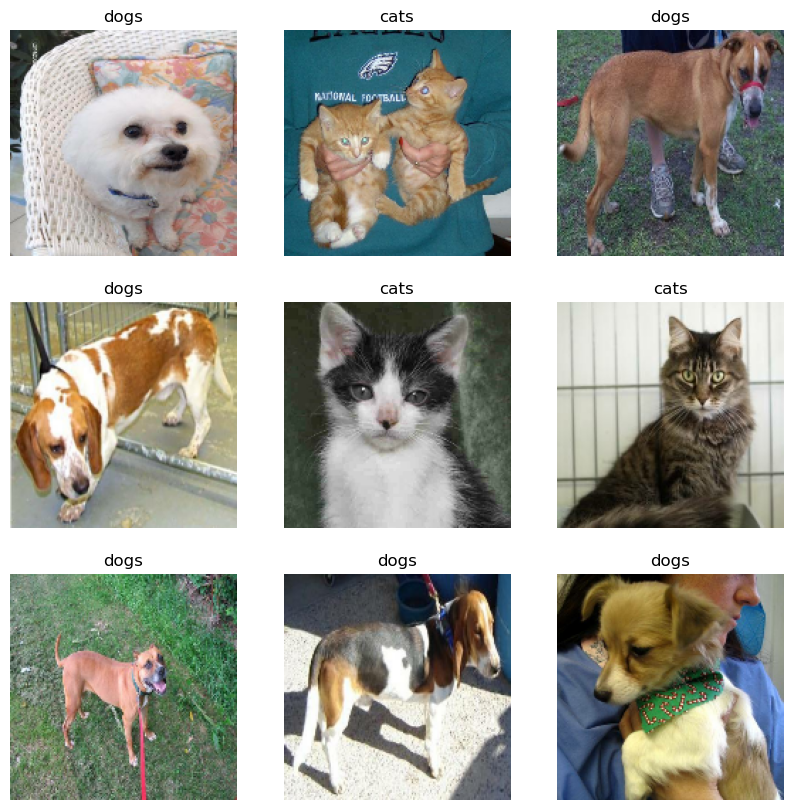

In [4]:
# Criando um laço para mostrar as primeiras nove imagens e rótulos do conjunto de treinamento:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
# Como o conjunto de dados original não contém um conjunto de teste, vamos criar um. Para fazer isso,
# determinaremos quantos lotes de dados estão disponíveis no conjunto de validação usando
# tf.data.experimental.cardinality e movendo 20% deles para um conjunto de teste. (era 32 e ficou 26 e 6)

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [7]:
# Configurar o conjunto de dados para desempenho
# Use a pré-busca em buffer para carregar imagens do disco sem que a E/S se torne um bloqueio.
# Ou seja, como estamos trabalhando com o transfer_learning, vamos trazer os datasets e fazer um
# autotune (afinar automaticamente) das features.

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
# Usar o aumento de dados
# Quando você não tem um grande conjunto de dados de imagem, é uma boa prática introduzir artificialmente
# a diversidade de amostra aplicando transformações aleatórias, porém realistas, às imagens de treinamento,
# como rotação e inversão horizontal. Isso ajuda a expor o modelo a diferentes aspectos dos dados de treinamento
# e reduzir o overfitting .


data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

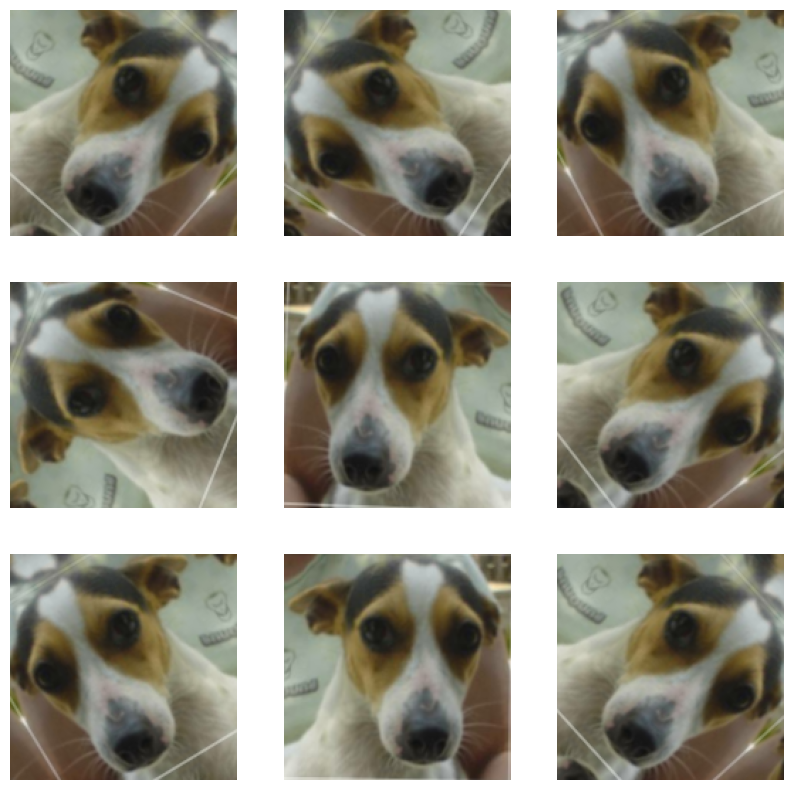

In [10]:
# Agora vamos aplicar repetidamente essas camadas na mesma imagem acima e ver o resultado.
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [12]:
# Redimensionar valores de pixel.
# Faremos o download do modelo base do google (tf.keras.applications.MobileNetV2).

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [13]:
# O modelo foi pré-treinado com valores de pixel em [-1, 1] , mas neste ponto, os valores de pixel das imagens
# baixadas estão em [0, 255] . Para redimensioná-los, usaremos o método de pré-processamento incluído no modelo.

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [14]:
# Criaremos agora o modelo base a partir do modelo MobileNet V2 desenvolvido no Google. 
# Ele foi pré-treinado no com um grande conjunto de dados que consiste em 1,4 milhão de imagens e 1.000 classes.

# ImageNet é um conjunto de dados de treinamento de pesquisa com uma ampla variedade de categorias, 
# como jackfruit e syringe . Essa base de conhecimento nos ajudará a classificar cães e gatos de nosso
# conjunto de dados específico.

# Primeiro, precisamos escolher qual camada do MobileNet V2 usaremos para extrair os recursos.
# A última camada de classificação não é muito útil (como o sentido é de baixo pra cima, a camada top é a última).
# Em vez disso, iremos até a camada antes da operação de nivelamento ("camada de gargalo").
# Os recursos da camada de gargalo retêm mais generalidade em comparação com a camada final/superior.

# Então, primeiro, instanciaremos um modelo MobileNet V2 pré-carregado com pesos treinados no ImageNet.
# Ao especificar o argumento include_top=False, estamos carregando uma rede que não inclui as camadas de
# classificação na parte superior, o que é ideal para extração de recursos.


# Então vamos pra criação do modelo base a partir do modelo MobileNet V2 desenvolvido no Google.
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 2s 0us/step


In [15]:
# Este extrator de recursos converte cada imagem de 160x160x3 em um bloco de recursos de 5x5x1280.
# Vamos ver o que ele faz com um exemplo de lote de imagens:


image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [16]:
# Extração de recursos
# Nesta etapa, congelaremos a base convolucional criada na etapa anterior e usaremos como extrator de recursos.
# Além disso, adicionaremos um classificador em cima dele e treinaremos o classificador de nível superior.

# Portanto, vamos ao congelamento da base convolucional.
# É importante congelar a base convolucional antes de compilar e treinar o modelo.
# O congelamento (definindo layer.trainable = False) evita que os pesos em uma determinada
# camada sejam atualizados durante o treinamento. O MobileNet V2 tem muitas camadas, portanto,
# definir o sinalizador trainable de todo o modelo como False irá congelar todas elas.

base_model.trainable = False

# Nota importante sobre camadas de BatchNormalization
# Muitos modelos contêm camadas tf.keras.layers.BatchNormalization. Essa camada é um caso especial
# e precauções devem ser tomadas no contexto do ajuste fino.
# Quando se define layer.trainable = False, a camada BatchNormalization será executada no
# modo de inferência e não atualizará suas estatísticas de média e variação.

# Quando descongelamos um modelo que contém camadas BatchNormalization para fazer o ajuste fino,
# você deve manter as camadas BatchNormalization no modo de inferência passando training = False ao
# chamar o modelo base. Caso contrário, as atualizações aplicadas aos pesos não treináveis ​​destruirão
# o que o modelo aprendeu.